In [76]:
import math
import numpy as np
import os
import pandas as pd
import pprint
import seaborn as sns

from rosbags.rosbag2.reader import Reader as BagReader

from copy import copy, deepcopy
from evo.tools import plot, pandas_bridge
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS
from evo.tools import file_interface
from evo.core import sync
from evo.core.sync import TrajectoryPair

from os import path
from tools.tum_plots import *
from tools.tum_tools import *


# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = True

%load_ext autoreload
%autoreload 2

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib widget

result_figure_dir = "/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/"


EKF_TOPIC = "/ekf_pose_with_covariance"
GT_GPS_TOPIC = "/ekf/gt/gps"
KISS_TOPIC = "/kiss/odometry"

N_RUNS = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting

### Data Read

In [63]:
# Root of all data
data_root = "/home/julian/projects/thesis/datasets/df_analysis/"

# Switch for the route (mdv3_1 / mdv3_2)
route = "mdv3_1"

# Read dataset configuration
# data_set = "01_no_kiss" # Only GPS & IMU are fused
data_set = "02_with_kiss" # Only GPS & IMU are fused

# Path with actual data
data_path = os.path.join(data_root, route, data_set)

if data_set.startswith("01"): result_figure_dir = os.path.join(result_figure_dir, "02-ekf-analysis/")
elif data_set.startswith("02"): result_figure_dir = os.path.join(result_figure_dir, "03_kiss_ekf-analysis")

data = {}


def read_trajectories_from_run(run):
    bag_path = os.path.join(data_path, f"run_{run:02d}")
    bag_reader = BagReader(bag_path)
    bag_reader.open()
    gps_file = path.join("data/reference/mdv3_1_reference.tum")

    traj_ref = file_interface.read_tum_trajectory_file(gps_file)
    traj_gt_gps = file_interface.read_bag_trajectory(bag_reader, GT_GPS_TOPIC)
    traj_ekf = file_interface.read_bag_trajectory(bag_reader, EKF_TOPIC)
    
    try:
        traj_kiss = file_interface.read_bag_trajectory(bag_reader, KISS_TOPIC)
    except:
        traj_kiss = None
    
    bag_reader.close()
    
    return traj_ref, traj_gt_gps, traj_ekf, traj_kiss

for i in range(1, N_RUNS +1):
    t = read_trajectories_from_run(i)
    data[i] = {"REF": t[0], "GT_GPS": t[1], "EKF": t[2], "KISS": t[3]}

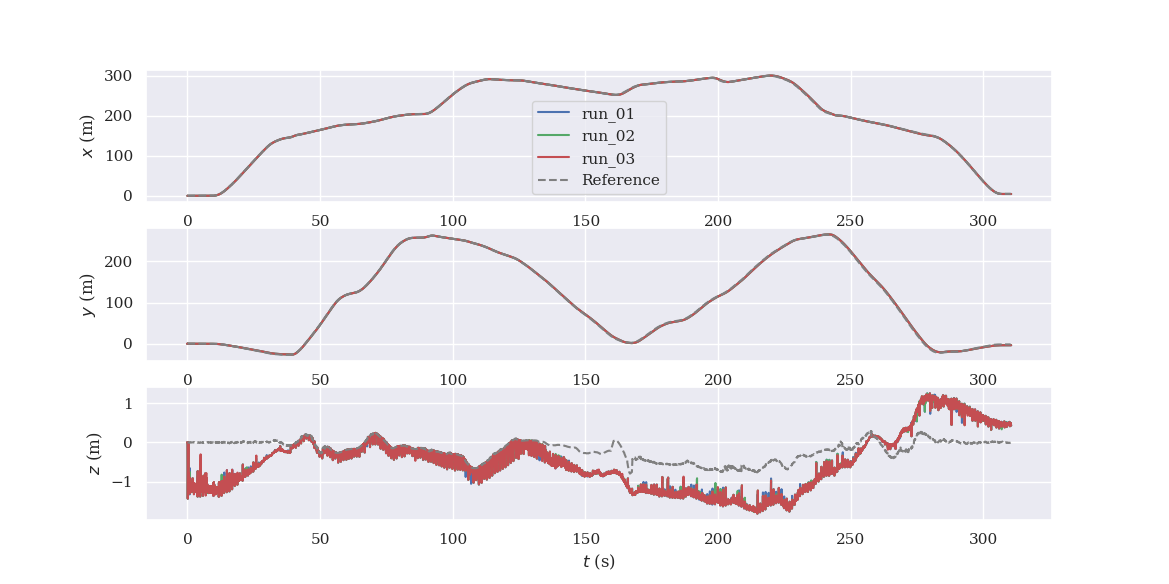

In [43]:
# Compare data across all runs of one test set
trajectory_type = "EKF"
plot_mode = "xyz"
trajectories, names = [],[]

for i in range(1, N_RUNS+1):
    names.append(f"run_{i:02d}")
    trajectories.append(data[i][trajectory_type])

names.append("Reference")
trajectories.append(data[1]["GT_GPS"])
compare_plot_multiple(trajectories, names, plot_mode=plot_mode, wf=2, hf=0.5)

# fig_name = f"compare_{route_switch}_{trajectory_type}_{version_switch}_{test_set_switch}_{plot_mode}.pdf"
# plt.savefig(path.join(result_figure_dir, fig_name), format="pdf", bbox_inches="tight")

## Trajectory Plot for all runs

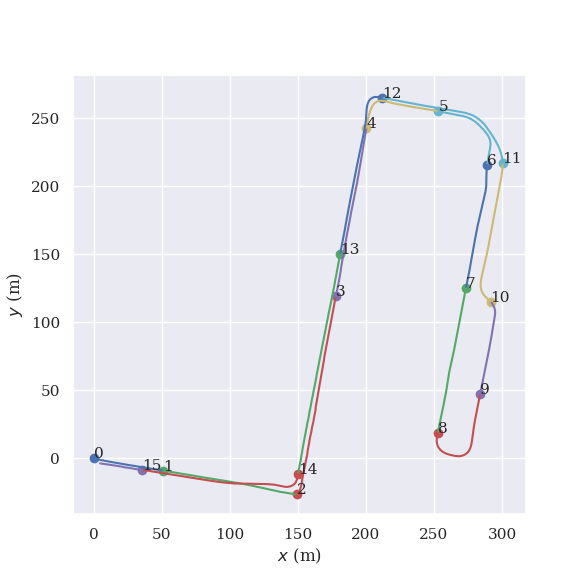

In [94]:
# Compare for Errors
run = 2
trajectory_type = "EKF"

traj_ref = deepcopy(data[run]['GT_GPS'])
traj_est = data[run][trajectory_type]

# plot_compare((traj_ref, traj_est), plot_mode='rpe', est_name=trajectory_type, print_stats=True, 
#              pose_relation=PoseRelation.translation_part, max_diff=0.001)

plot_trajectory_segments(traj_ref, wf=1, hf=1)
# plt.savefig(path.join(result_figure_dir, f"{route}_ape_trajectory.pdf"), format="pdf", bbox_inches="tight")

In [ ]:
f133b47cf9e88bd3b349502491f13f1c4b8de9b7eae003f84f5b055a46f95cfe  local
f133b47cf9e88bd3b349502491f13f1c4b8de9b7eae003f84f5b055a46f95cfe

## APE

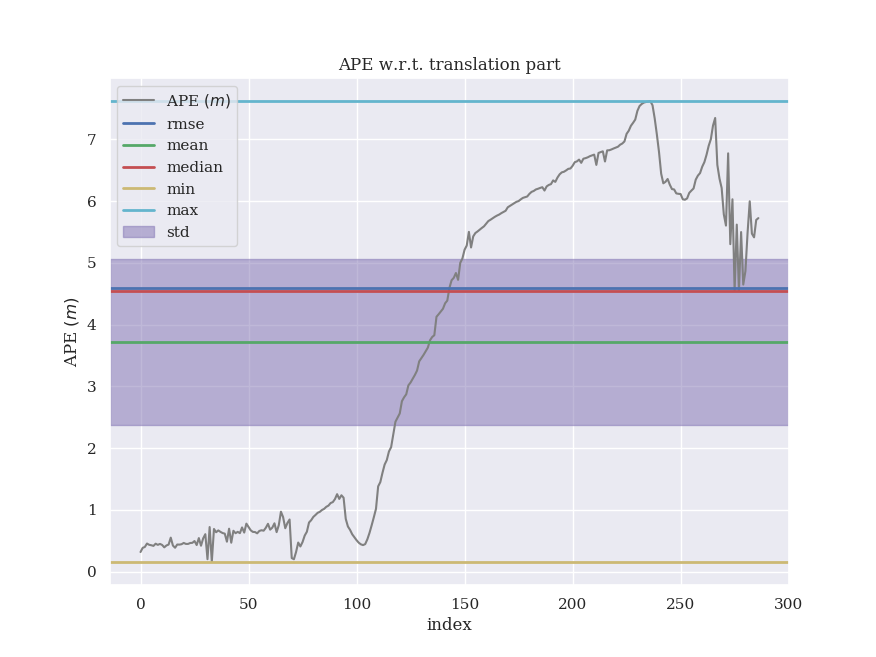

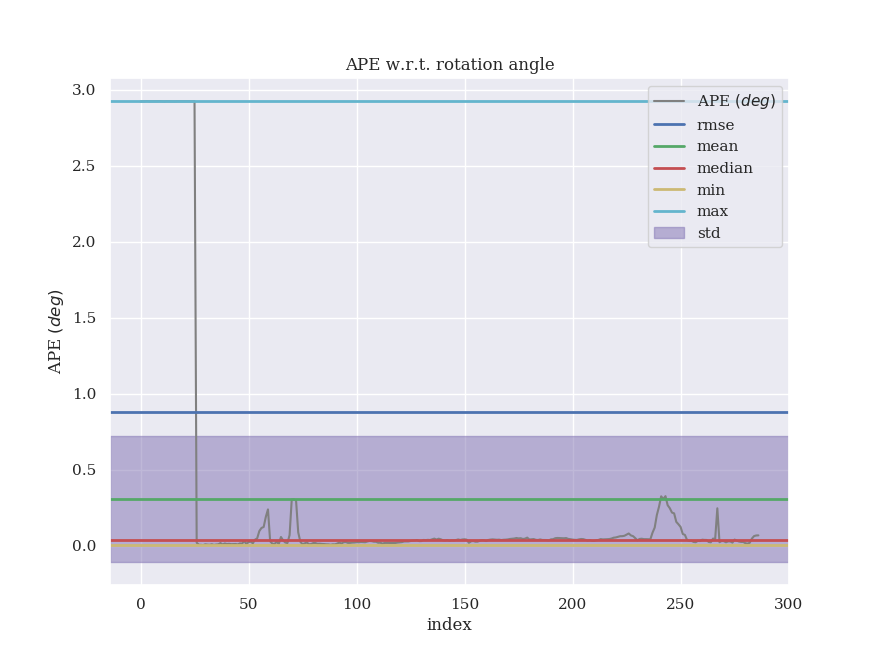

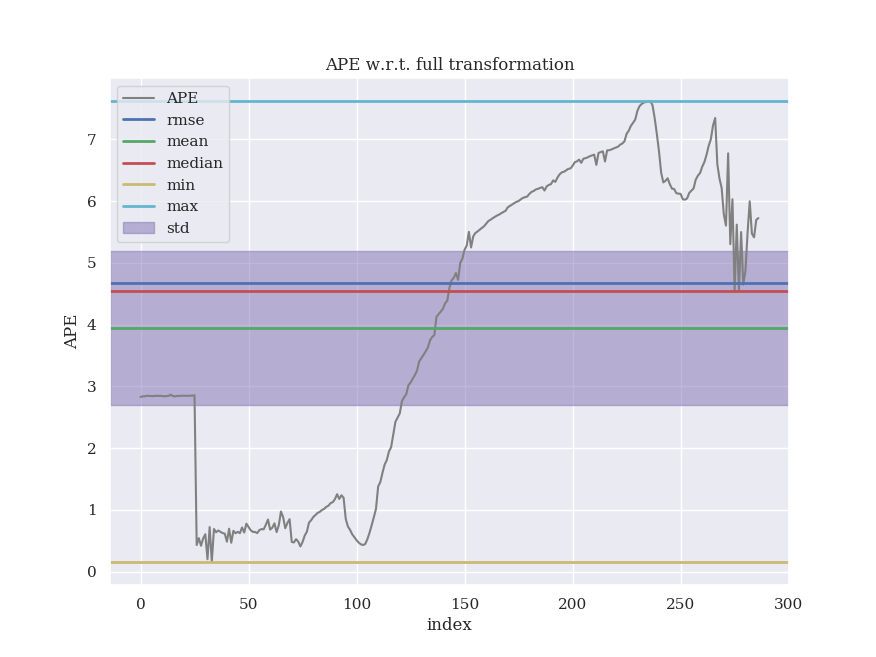

In [62]:
plt.close('all')

run = 1

pose_relations = [metrics.PoseRelation.translation_part, metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run]["EKF"])
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.001)


for pose_relation in pose_relations:
    ape_metric = metrics.APE(pose_relation=pose_relation)
    ape_metric.process_data((traj_ref, traj_est))
    # plot_statistical_error_metric(ape_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    plot_statistical_error_metric(ape_metric, show_plot=False, save_dir="", name_prefix=route)


In [43]:
traj_ref.timestamps[0]

1689869691.9800308

## RPE

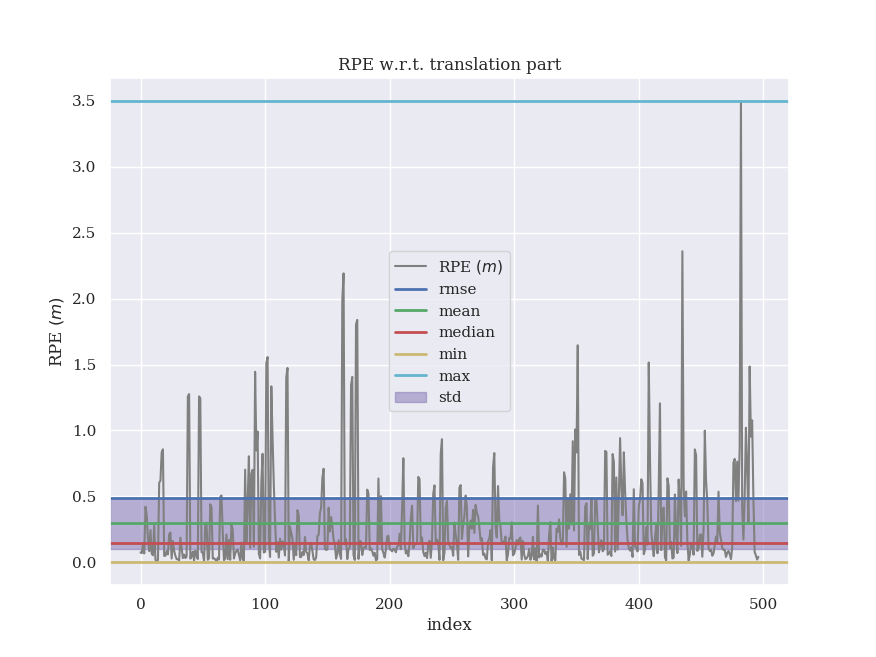

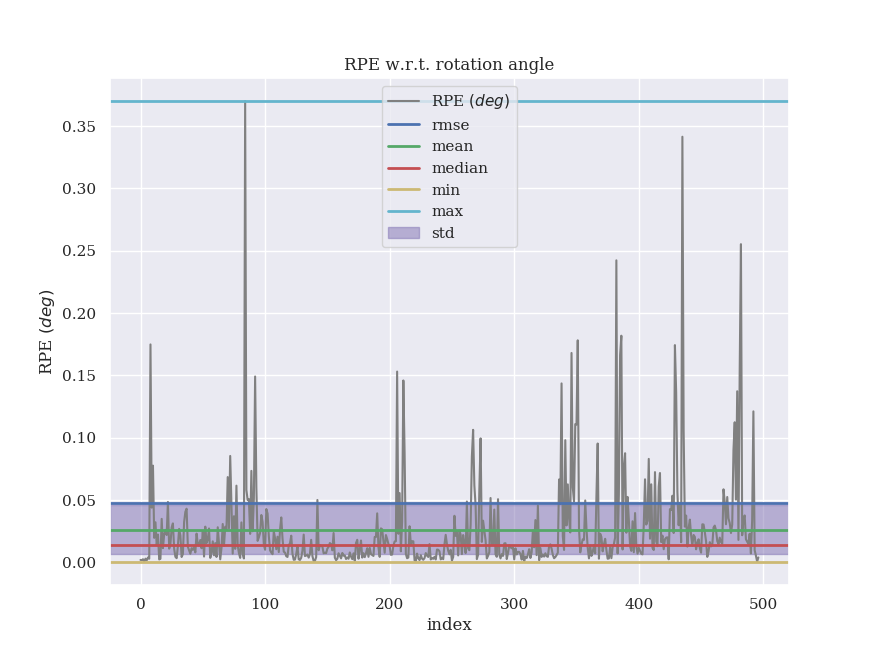

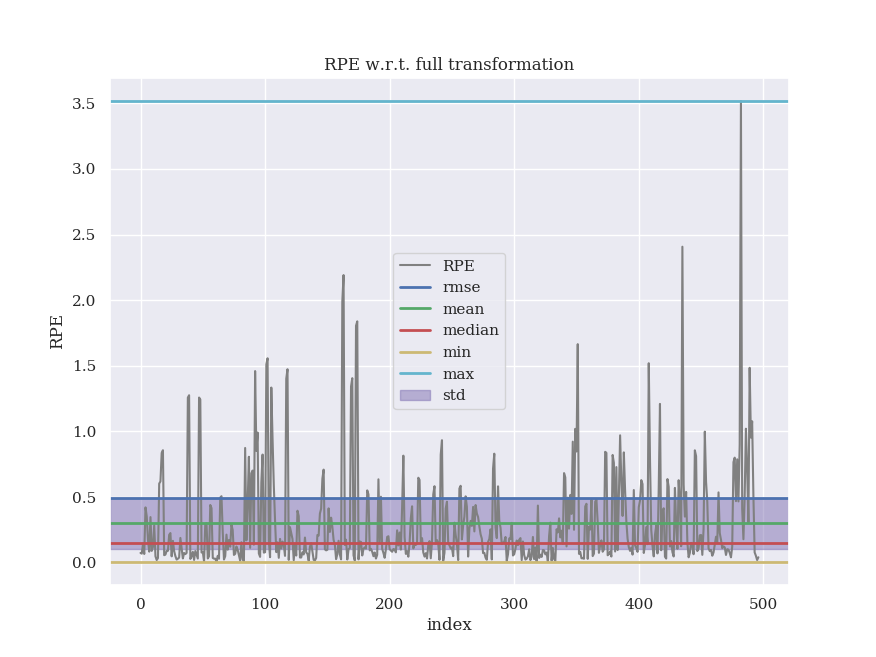

In [46]:
plt.close('all')

delta = 1
all_pairs = False 
delta_unit = Unit.frames

run = 1

pose_relations = [metrics.PoseRelation.translation_part, metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run]["EKF"])
# traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.01)
traj_est, traj_ref = sync.associate_trajectories(traj_est, traj_ref, max_diff=0.001)


for pose_relation in pose_relations:
    rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
    rpe_metric.process_data((traj_ref, traj_est))
    # plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir="", name_prefix=route)


# traj_ref_plot = deepcopy(traj_ref)
# traj_est_plot = deepcopy(traj_est)
# traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
# traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]


## Advanced Plots for direct comparison

In [ ]:


colormap = SETTINGS.plot_multi_cmap

df = pandas_bridge.result_to_df(result, "EKF")
keys = df.columns.values.tolist()
error_df = pd.DataFrame(df.loc["np_arrays", "error_array"].tolist(),
                                index=keys).T

metric_label = df.loc["info", "label"].iloc[0]
print(f"Metic Label: {metric_label}")

# fig_raw = plt.figure(figsize=get_figsize())
# # handle NaNs from concat() above
# error_df.interpolate(method="index", limit_area="inside").plot(
#     ax=fig_raw.gca(), title="", alpha=SETTINGS.plot_trajectory_alpha)
# # plt.xlabel(index_label)
# # plt.ylabel(metric_label)
# plt.legend(frameon=True)
# plt.show()

# fig_stats = plt.figure(figsize=get_figsize())
# include = df.loc["stats"].index.isin(SETTINGS.plot_statistics)
# if any(include):
#     df.loc["stats"][include].plot(kind="barh", ax=fig_stats.gca(), stacked=False)
#     # plt.xlabel(metric_label)
#     plt.legend(frameon=True)
# plt.show()
plt.close('all')
# print(df)
raw_tidy = pd.melt(error_df, value_vars=list(error_df.columns.values), var_name="estimate", value_name=metric_label)
# print(raw_tidy)
# col_wrap = 2 if len(args.result_files) <= 2 else math.ceil(len(args.result_files) / 2.0)
# dist_grid = sns.FacetGrid(raw_tidy, col="estimate", col_wrap=2)
# dist_grid.map(sns.distplot, metric_label)  # fits=stats.gamma
# sns.histplot(data=raw_tidy, x=metric_label, kde=True)
data = raw_tidy[metric_label].to_numpy()
data = np.array(data)
data= data[..., np.newaxis]
print(data.shape)
# sns.histplot(data=(raw_tidy[metric_label]).to_numpy(), stat='density', kde=True)
sns.histplot(data=data, stat='density', kde=True)
# sns.displot(data=raw_tidy[metric_label], )


# fig_box = plt.figure(figsize=get_figsize())
# ax = sns.boxplot(x=raw_tidy["estimate"], y=raw_tidy[metric_label],
                    #  ax=fig_box.gca())
    # ax.set_xticklabels(labels=[item.get_text() for item in ax.get_xticklabels()], rotation=30)
# plt.show()
    
# violin plot
# fig_violin = plt.figure(figsize=get_figsize())
# ax = sns.violinplot(x=raw_tidy["estimate"], y=raw_tidy[metric_label],
#                     ax=fig_violin.gca())
# ax.set_xticklabels(labels=[item.get_text() for item in ax.get_xticklabels()], rotation=30)
# plt.show()
